## **Microsoft Stocks Project**

**The purpose** of this model is to find patterns in Microsoft's stock price having the past stocks data.

**The goal** of this model is to predict the Microsoft's stock price based on the data at hand.

*This model's components are labeled with the respective **PACE stage: Plan, Analyze, Construct, Execute**.*

At first, we import packages and libraries needed to build the XGBoost model and evaluate its performance.

In [30]:
# Import packages for data manipulation
import numpy as np
import pandas as pd

# Import XGBoost Regressor model package
from xgboost import XGBRegressor

# Import packages for data visualization 
import matplotlib.pyplot as plt

# Import packages for data modeling
from sklearn.model_selection import GridSearchCV, train_test_split

# Import packages for metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Import packages to handle missing data
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# This lets us see all the columns, preventing Jupyter from redacting them.
pd.set_option('display.max_columns', None)

Now we read in the dataset as `df0` and inspect the first five rows.

In [31]:
# Import dataset
df0 = pd.read_csv('MicrosoftStocks.csv')

# Inspect the first five rows
df0.head()

,Date,Price,Open,High,Low,Volume
0,05/15/2023,309.46,309.10,309.90,307.59,16290000
1,05/12/2023,308.97,310.55,310.65,306.60,19770000
2,05/11/2023,310.11,310.10,311.12,306.26,31680000
3,05/10/2023,312.31,308.62,313.00,307.67,30080000
4,05/09/2023,307.00,308.00,310.04,306.31,21340000


At this stage, we are going to engineer features and, from the existing features, new features to use in the modeling and improvement of the model performance and prediction accuracy.

Let's create a copy of `df0` to preserve the original datafram and call the copy `df`.

In [32]:
# Copy the dataframe
df = df0.copy()

Calling `info()` on the new dataframe so the columns in the datafram can be easily referenced.

In [33]:
# Show the info about our dataframe
df.info

<bound method DataFrame.info of             Date   Price    Open    High     Low     Volume
0     05/15/2023  309.46  309.10  309.90  307.59   16290000
1     05/12/2023  308.97  310.55  310.65  306.60   19770000
2     05/11/2023  310.11  310.10  311.12  306.26   31680000
3     05/10/2023  312.31  308.62  313.00  307.67   30080000
4     05/09/2023  307.00  308.00  310.04  306.31   21340000
...          ...     ...     ...     ...     ...        ...
9364  03/20/1986    0.10    0.10    0.10    0.09   58440000
9365  03/19/1986    0.10    0.10    0.10    0.10   47890000
9366  03/18/1986    0.10    0.10    0.10    0.10   66470000
9367  03/17/1986    0.10    0.10    0.10    0.10  133169999
9368  03/14/1986    0.10    0.10    0.10    0.10  308160000

[9369 rows x 6 columns]>

#### `Date Modification`

The date column in our original dataframe has the date in object format. We need to modify it by calling the `to_datetime()` on our `Date` column to convert it into Pandas date format.

In [34]:
# Modify the 'Date' in the dataframe
df['Date'] = pd.to_datetime(df['Date'])

Now, we extract the `year`, `month`, `dayofweek`, and `quarter` from the `Date` as it will help us in finding the seasonal patterns in the data. 

In [35]:
# Create a new column for year
df['year'] = df['Date'].dt.year

# Create a new column for month
df['month'] = df['Date'].dt.month

# Create a new column for day of week
df['day'] = df['Date'].dt.dayofweek

# Create a new column for the quarter
df['quarter'] = df['Date'].dt.quarter

#### `daily_range`

Creating a new feature called `daily_range` that represents the difference between the highest and the lowest trading prices of stock in a day. 

*Note: In substracting the values of the two columns `High` and `Low`,  Pandas use vectorization in calculating the values for the `daily_range`, utilizing parallel hardware of the GPU.*

In [36]:
# Create a new feature 'daily_range' (high - low)
df['daily_range'] = df['High'] - df['Low']

#### `volume_change`

Creating a feature called `volume_change` that represents the percentage change in the volume. It is a measure of how much the volume changed from one day to the next.

In [37]:
# Create a new feature `volume_change`
df['volume_change'] = df['Volume'].pct_change()

#### `price_increase`

Creating a new binary feature called `price_increase` that represents whether or not the price increased since the day before. 

In [38]:
# Create a new feature `price_increase`
df['price_increase'] = (df['Price'] > df['Price'].shift(1)).astype(int)

#### `Calculating the MACD`

MACD (Moving Average Convergence Divergence) is an indicator in stock market analysis to identify trends and momentum in a stock's price. 

It provides us with:

* The Exponential Moving Average (EMA) in short-term `shortEMA`

* The Exponential Moving Average (EMA) in long-term `longEMA`

* The `MACD` value that helps us identify the convergence or divergence of the short and long-term trends.

In [39]:
def calculate_macd(df, short_window=12, long_window=26, signal_window=9):
    """
    Calculate the Moving Average Convergence Divergence (MACD) indicator for a given DataFrame.

    Parameters:
        df (DataFrame): DataFrame containing the stock price data. It should have a 'Date' column and a 'Price' column.
        short_window (int): Number of days for the short-term moving average (default is 12).
        long_window (int): Number of days for the long-term moving average (default is 26).
        signal_window (int): Number of days for the signal line moving average (default is 9).

    Returns:
        DataFrame: A new DataFrame containing the MACD, signal line, and MACD histogram.
    """
    df['shortEMA'] = df['Price'].ewm(span=short_window, adjust=False).mean()

    df['longEMA'] = df['Price'].ewm(span=long_window, adjust=False).mean()

    df['MACD'] = df['shortEMA'] - df['longEMA']

    df['signalLine'] = df['MACD'].ewm(span=signal_window, adjust=False).mean()

    df['MACD_histogram'] = df['MACD'] - df['signalLine']

    return df

Now, we concatenate the dataframe we returned from `calculate_macd` function with the copy of our original dataframe `df`.

In [40]:
# Concatenate the dataframes
df = pd.concat([df, calculate_macd(df)], axis=0)
df.head()

,Date,Price,Open,High,Low,Volume,year,month,day,quarter,daily_range,volume_change,price_increase,shortEMA,longEMA,MACD,signalLine,MACD_histogram
0,2023-05-15,309.46,309.10,309.90,307.59,16290000,2023,5,0,2,2.31,NaN,0,309.460000,309.460000,0.000000,0.000000,0.000000
1,2023-05-12,308.97,310.55,310.65,306.60,19770000,2023,5,4,2,4.05,0.213628,0,309.384615,309.423704,-0.039088,-0.007818,-0.031271
2,2023-05-11,310.11,310.10,311.12,306.26,31680000,2023,5,3,2,4.86,0.602428,1,309.496213,309.474540,0.021673,-0.001920,0.023592
3,2023-05-10,312.31,308.62,313.00,307.67,30080000,2023,5,2,2,5.33,-0.050505,1,309.929103,309.684575,0.244529,0.047370,0.197159
4,2023-05-09,307.00,308.00,310.04,306.31,21340000,2023,5,1,2,3.73,-0.290559,0,309.478472,309.485717,-0.007245,0.036447,-0.043692



In the above dataset, we can see that the new features are successfully added, though we have `NaN` or missing values. We use the method `isnull()` and `sum()` to check for missing values.

In [41]:
# Count the numebr of NaN values in the dataset
nan_count = df.isnull().sum().sum()

# Print the number of NaN values. 
print("Total NaN values:", nan_count)

Total NaN values: 2


We have 8 `NaN` values in our dataset, and missing values adversly affect the model's performance. That is why we are going to handle missing values using scikit-learn's imputer `IterativeImputer()`.

An imputer treats missing values as it's target variable, uses a linear regression model to predict the missing value based on the other features, and updates the missing value with the predicted value. 

*Note: XGBoost model can handle the missing values itself, but it is a crucial step in developing the model to ensure the missing values are handled properly to avoid any negative impact on the model performance. Although iterative imputation is a computationally intensive method, it provides better imputation accuracy, and since it alligns with the ethical consideration of our model -- avoiding negative financial impact to the clients -- we will utilize that.*

In [42]:
# Put the columns with missing values into a list
columns_with_missing_values = df.columns[df.isnull().any()].tolist()

# Initialize the imputer
imputer = IterativeImputer(max_iter=10, random_state=42)

# Fit the columns into the imputer
imputer.fit(df[columns_with_missing_values])

# Impute missing values in specific columns
imputed_data = imputer.fit_transform(df[columns_with_missing_values])

# Update the datafram with the imputed values
df[columns_with_missing_values] = imputed_data

Now that we handled the missing values, we should check and make sure there are no more missing values in our dataset.

In [43]:
# Count the numebr of NaN values in the dataset
nan_count = df.isnull().sum().sum()

# Print the number of NaN values. 
print("Total NaN values:", nan_count)

Total NaN values: 0


Now that we don't have any missing values in our dataset, it's time to isolate our `X` and `y` variables and specific columns for them. After isolating them, we check to make sure we have the right features for each of them.

* We already extracted the necessary information from the `Date` column, so we are dropping it from our `X` variable since it does not contribute much to the model prediction.



* We are dropping the `Price` from our `X` variable because it is what we are trying to predict (our `y` variable).

In [44]:
# Isolate X variable
X = df.drop(columns = ['Price', 'Date'])
X.head()

,Open,High,Low,Volume,year,month,day,quarter,daily_range,volume_change,price_increase,shortEMA,longEMA,MACD,signalLine,MACD_histogram
0,309.10,309.90,307.59,16290000,2023,5,0,2,2.31,0.085302,0,309.460000,309.460000,0.000000,0.000000,0.000000
1,310.55,310.65,306.60,19770000,2023,5,4,2,4.05,0.213628,0,309.384615,309.423704,-0.039088,-0.007818,-0.031271
2,310.10,311.12,306.26,31680000,2023,5,3,2,4.86,0.602428,1,309.496213,309.474540,0.021673,-0.001920,0.023592
3,308.62,313.00,307.67,30080000,2023,5,2,2,5.33,-0.050505,1,309.929103,309.684575,0.244529,0.047370,0.197159
4,308.00,310.04,306.31,21340000,2023,5,1,2,3.73,-0.290559,0,309.478472,309.485717,-0.007245,0.036447,-0.043692


* Assign the `Price` as our `y` variable

In [45]:
# Isolate the y variable
y = df['Price']
y.head()

0    309.46
1    308.97
2    310.11
3    312.31
4    307.00
Name: Price, dtype: float64

Now we split the data as planned on our **Construct** stage.

In [46]:
# Split the data into train and test sets
X_tr, X_test, y_tr, y_test = train_test_split(X, y, 
                                              test_size=0.2, random_state=42)

# Further split the train sets into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, 
                                                  test_size=0.25, random_state=42)

After having the partitions, it's time to verify the number of samples in each partition.

In [47]:
# Total number of samples
print(df.shape[0])

18738


In [48]:
# Verify the partitions
for x in [X_train, X_val, X_test]:
    print(len(x))

11242
3748
3748


Out of 74952 samples that we have, 60% of it is ~44971, and 20% of it is ~14990, so the number of samples in each partition perfectly aligns with our expectations.

**XGBoost**

We begin with Grid Search Cross-Validation (`GridSeachCV`) to tune the XGBoost model.

1. We instantiate the XGBoost regressor `xgb` and set the random state


In [49]:
# Model instantiation
xgb = XGBRegressor(random_state=42)


2. Then, we create the dictionary `cv_params` of the following hyperparameters and their corresponding values to tune. 

* `max_depth`
* `min_child_weight`
* `learning_rate`
* `n_estimators`
    


In [50]:
# The dictionary for hyperparameters
cv_params = {'max_depth': [6, 12],
             'min_child_weight': [3, 5],
             'learning_rate': [0.01, 0.1],
             'n_estimators': [300]
             }

3. Define a dictionary `scoring` of the following scoring metrics for GridSearch to capture:

* `neg_mean_squared_error`
* `r2`
* `neg_mean_absolute_error`


In [51]:
# Scoring dictionary
scoring = {'neg_mean_squared_error', 
           'r2', 
           'neg_mean_absolute_error',
            }


4. Lastly, we instantiate the `GridSearchCV` object `xgb_cv` and pass to it the above arguements we made:

* estimator=`xgb`
* param_grid=`cv_params`
* scoring=`scoring`
* cv=`5` (number of cross validtion folds)
* refit=`neg_mean_squared_error` (the metric we want to evaluate the performance of different hyperparamter combinations)

*Note: We chose `neg_mean_squared_error` as the metric we want to evaluate the model performance because Mean Squared Error measures the squared difference between our predicted values and the actual values, or in other words, how far our prediction is from the true values. The reason we chose the **Negative** Mean Squared Error specifically is that when it's maximized, the actual mean squared error will be minimized, which aligns well with scikit-learn's scoring functions.*

In [52]:
# GridSearch Instantiation
xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=5, refit='neg_mean_squared_error')

Now we fit the model to the training data.

*Note: This cell will utilize a higher percentage of CPU. It is recommended that you monitor your CPU performance and make sure the performance doesn't result in excessive overheat of the computer since continuous high CPU usage and overheat results in bad perfomance, data loss, or system instability. You can monitor your CPU performance by opening `Task Manager` on Windows or  `Activity Monitor` on IOS.* 

In [53]:
%%time
# Fit the model to the training data
xgb_cv.fit(X_train, y_train)

CPU times: total: 11min 48s
Wall time: 1min 3s


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=4

Now that we fitted the model, it is time to get its components. First, let's check the best score.

In [54]:
# Print the best score
xgb_cv.best_score_

-0.4088841633537574

And the best parameters.

In [55]:
# Print the best parameteres
xgb_cv.best_params_

{'learning_rate': 0.1,
 'max_depth': 12,
 'min_child_weight': 5,
 'n_estimators': 300}

Visualizing the scores is an important step in our model development. With a clear understanding of the model's scores, we can have an idea of how well it's performing, and whether it needs modifications or not. 

For a clear visualization of the scores, we are going to make the `make_results()` function. This function accepts three arguments and outputs all of the scores of our model. 

In [56]:
def make_results(model_name:str, model_object, metric:str):
    '''
    Arguments:
        model_name (string): what you want the model to be called in the output table
        model_object: a fit GridSearchCV object
        metric (string): 'neg_mean_squared_error', 'r2', or 'neg_mean_absolute_error'

        Returns a pandas df with the 'neg_mean_squared_error','r2', and 'neg_mean_absolute_error'
        for the model with the best mean 'metric' score across all validation folds
    '''

    # Create dictionary that maps inputs metric to actual metric name in GridSearchCV
    metric_dict = {'mse': 'mean_test_neg_mean_squared_error',  # Use 'mean_test_' prefix for GridSearchCV's metrics
                   'r2': 'mean_test_r2',
                   'mae': 'mean_test_neg_mean_absolute_error'
                    }
    
    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract MSE, R2, MAE from that row
    mse = best_estimator_results.mean_test_neg_mean_squared_error
    r2 = best_estimator_results.mean_test_r2
    mae = best_estimator_results.mean_test_neg_mean_absolute_error

    # Create a table of results
    table = pd.DataFrame({'model' : [model_name],
                          'MSE' : [mse],
                          'R2' : [r2],
                          'MAE' : [mae]
                          })
    
    return table
    

Now that the function is ready to make a table out of our scores, we will pass the `GridSearch` object to the `make_results()` function

In [57]:
# Make the results table with our model scores
xgb_cv_results = make_results('XGB CV', xgb_cv, 'mse')
xgb_cv_results

,model,MSE,R2,MAE
0,XGB CV,-0.408884,0.999917,-0.190525


Above, we can see a table of the scores. Now it's time to define the function `get_test_scores` to generate a table of scores from the **prediction** and **validation** scores.

In [58]:
def get_test_scores(model_name:str, preds, y_test_data):
    '''
    Generate a table of test scores

    In:
        model_name (string): how the model will be named in the output table
        preds: numpy array of test predictions
        y_test_data: numpy array of y_test data

    Out:
        table: a pandas df of MAE, MSE, and R2 scores for the model
    '''
    mse = mean_squared_error(y_test_data, preds)
    mae = mean_absolute_error(y_test_data, preds)
    r2score = r2_score(y_test_data, preds)

    table = pd.DataFrame({'model' : [model_name],
                          'MSE':[mse],
                          'MAE':[mae],
                          'R2':[r2score]
                          })
    
    return table
    

Now, we take the model's scores on the validation data and add it to our results table.

In [59]:
# Use XGBoost model to predit on validation data
xgb_val_preds = xgb_cv.best_estimator_.predict(X_val)

# Get the validation test scores for XGBoost model
xgb_val_scores = get_test_scores('XGB Val', xgb_val_preds, y_val)

# Concatenate the model scores and the validation scores tables
results = pd.concat([xgb_cv_results, xgb_val_scores], axis=0)
results

,model,MSE,R2,MAE
0,XGB CV,-0.408884,0.999917,-0.190525
0,XGB Val,0.271265,0.999943,0.143244


Above, we have a table that has both scores of our model and the scores on the validation data. So far, we have an idea of the model's performance, which, based on the values of the MSE, R2, and MAE, it is performing pretty well.



As a final step, we are going to use the model to predict on the test data. This steps shows how the model will perform on completely new, unseen data. 

In [60]:
# Use our XGBoost model to predict on test data
xgb_test_preds = xgb_cv.best_estimator_.predict(X_test)

# Get test scores for our XGBoost model
xgb_test_scores = get_test_scores('XGB Test', xgb_test_preds, y_test)

# Append to the results table
results = pd.concat([results, xgb_test_scores], axis=0)
results

,model,MSE,R2,MAE
0,XGB CV,-0.408884,0.999917,-0.190525
0,XGB Val,0.271265,0.999943,0.143244
0,XGB Test,0.217163,0.999956,0.137317


The model performs exceptionally well; the `r2` score is very close to 1, and the MSE and MAE values are decently low. 

In order to get the `weight` and `gain` scores, we first have to get the booster `get_booster()` of our model's `best_estimator`

In [61]:
# Get the booster of the model's best estimator
booster = xgb_cv.best_estimator_.get_booster()

Now that we have the booster, we proceed to displaying the `weight` plot.

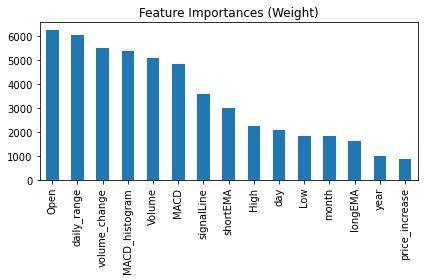

In [65]:
# Get feature importances based on 'weight'
importances_weight = booster.get_score(importance_type='weight')

# Convert the importance dictionary to a pandas Series
xgb_importances_weight = pd.Series(importances_weight)

# Sort the values of the series in decending order
xgb_importances_weight = xgb_importances_weight.sort_values(ascending=False)

# Create the figure and the axis
fig_weight, ax_weight = plt.subplots()

# Create a bar plot and set the axis as `ax_weight`
xgb_importances_weight.plot.bar(ax=ax_weight)

# Set the title for the plot
ax_weight.set_title('Feature Importances (Weight)')

# Adjust the spacing between the plot elements
fig_weight.tight_layout()

And the `gain` plot.

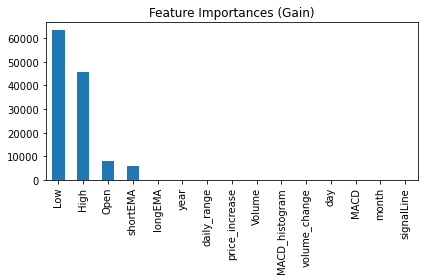

In [66]:
# Get feature importances based on 'gain'
importances_gain = booster.get_score(importance_type='gain')

# Convert the importance dictionary to a pandas Series
xgb_importances_gain = pd.Series(importances_gain)

# Sort the Series by importance
xgb_importances_gain = xgb_importances_gain.sort_values(ascending=False)

# Create the figure and the axis
fig_gain, ax_gain = plt.subplots()

# Create a bar plot and set the axis as `ax_gain`
xgb_importances_gain.plot.bar(ax=ax_gain)

# Set the title for the plot
ax_gain.set_title('Feature Importances (Gain)')

# Adjust the spacing between the plot elements
fig_gain.tight_layout()

In the `weight` plot, we can see that, alongside the features we originally had -- High, Low, Open, Volume, and date-related features --, the engineered features are also used significantly, which shows the importance of feature engineering.

In the `gain` plot, we see that our engineered `shortEMA` `feature also contributed in reducing the model's loss, and that is definitely valuable in improving the model's performance. 

Now, we are done with the development of this model. 